In [1]:
%load_ext autoreload
%autoreload 2

# Load EMA weights

In [2]:
from pathlib import Path
from omegaconf import OmegaConf

import torch
from plaid.diffusion import FunctionOrganismDiffusion
from plaid.denoisers import FunctionOrganismDiT, DenoiserKwargs
from plaid.constants import COMPRESSION_INPUT_DIMENSIONS, COMPRESSION_SHORTEN_FACTORS

device = torch.device("cuda")

In [3]:
model_id = "4hdab8dn"

ckpt_dir = Path("/data/lux70/plaid/checkpoints/plaid-compositional") 
model_path = ckpt_dir / model_id / "last.ckpt"
config_path = ckpt_dir / model_id / "config.yaml"

cfg = OmegaConf.load(config_path)

In [4]:
compression_model_id = cfg['compression_model_id']
shorten_factor = COMPRESSION_SHORTEN_FACTORS[compression_model_id]
input_dim = COMPRESSION_INPUT_DIMENSIONS[compression_model_id]

In [5]:
denoiser_kwargs = cfg.denoiser
denoiser_kwargs.pop("_target_")
denoiser = FunctionOrganismDiT(**denoiser_kwargs, input_dim=input_dim)

In [6]:
# lask.ckpt automatically links to the EMA

ckpt = torch.load(model_path)
# ckpt.keys()

In [7]:
mod_state_dict = {}
for k, v in ckpt['state_dict'].items():
    if k[:16] == "model._orig_mod.":
        mod_state_dict[k[16:]] = v

In [8]:
denoiser.load_state_dict(mod_state_dict)

<All keys matched successfully>

In [9]:
diffusion_kwargs = cfg.diffusion
diffusion_kwargs.pop("_target_")

# diffusion_kwargs['beta_scheduler_name'] = "sigmoid"
diffusion_kwargs['sampling_timesteps'] = 500

diffusion = FunctionOrganismDiffusion(model=denoiser,**diffusion_kwargs)

In [10]:
from cheap.pretrained import load_model_from_id
cheap_model = load_model_from_id(compression_model_id)
_ = cheap_model.to(device)

from cheap.proteins import LatentToSequence,LatentToStructure
latent_to_sequence = LatentToSequence()
latent_to_sequence.to(device)

latent_to_structure = LatentToStructure()
latent_to_structure.to(device)

Using tanh layer at bottleneck...
Finished loading HPCT model with shorten factor 2 and 32 channel dimensions.


Creating ESMFold...
ESMFold model loaded in 37.64 seconds.


# Sample
Human, carbohydrate metabolic process:

In [11]:
# organism_idx = org_df[org_df.organism_id == "HUMAN"].organism_index.iloc[0]
# function_idx = go_df[go_df.GO_term == "carbohydrate metabolic process"].GO_idx.iloc[0]
# print(organism_idx, function_idx)


In [12]:
device = torch.device("cuda")
diffusion = diffusion.to(device)

In [13]:
from plaid.datasets import NUM_ORGANISM_CLASSES, NUM_FUNCTION_CLASSES

N, L = 32, 128
shape = (N, L, input_dim)

organism_idx = NUM_ORGANISM_CLASSES
function_idx = NUM_FUNCTION_CLASSES
cond_scale = 0

diffusion.sampling_timesteps=500
diffusion
sampled_latent = diffusion.ddim_sample_loop(shape, function_idx,organism_idx, return_all_timesteps=True, cond_scale=cond_scale)

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

In [14]:
print(sampled_latent.shape)
final_sample = sampled_latent[:, -1, :, :]
print(final_sample.shape)

print(final_sample.max(), final_sample.min())

torch.Size([32, 501, 128, 32])
torch.Size([32, 128, 32])
tensor(1.0033, device='cuda:0') tensor(-1.0184, device='cuda:0')


In [15]:
sampled_uncompressed = cheap_model.decode(final_sample, downsampled_mask=None)
print(sampled_uncompressed.min(), sampled_uncompressed.max())

tensor(-1.0828, device='cuda:0') tensor(1.2528, device='cuda:0')


In [16]:
# import pickle as pkl
# with open("test_sample.pkl", "wb") as f:
#     pkl.dump(sampled_uncompressed,f)

In [17]:
from cheap.utils import LatentScaler
latent_scaler = LatentScaler()
sampled_unscaled = latent_scaler.unscale(sampled_uncompressed) 

In [18]:
print(sampled_unscaled.shape)
print(sampled_unscaled.max(), sampled_unscaled.min())

torch.Size([32, 256, 1024])
tensor(2889.9697, device='cuda:0') tensor(-862.0886, device='cuda:0')


In [19]:
sequences = latent_to_sequence.to_sequence(sampled_unscaled)[-1]

In [20]:
sequences[:3]

['ALISDADSVLWREDLIDIFRRLGMDLDVVRADSRLIDIGWTLRSLIANKVRRLHETQAGQIVYVACTTVCPGPINEASQAPVVVASDEPVLSPGFYTVGGFQLPGEDALQMLRAMRRLGPRPPAVVVAQGLREAGSPRSHLRRYLGPGATQALTAADLFTFPLDWLKALRPSASVVFSPLAHTVHEAFAAIGLPNATAHAREAVARAHEAFGFTQCAWLAPSSGCDGRIEKVLKSPLPEILHEVAGEIDTLHEILK',
 'RDFEIYLSTFRRSEDELQSILEARAGHVSPLPRVDVWTLNSDDNIGFIAESFEQLQLKNVIMIRFAKALRFDTLYRLTERLEWPFSAVWVFPDGVHYSVNGVAVTNARFLGHHRFWTSQKELQLLAECVVGVTYIYKAERLAEEYIATGRRDTVTGENPTTDPTIHKYFQDAIPILVAAGVRLWSVKGIFASSDVFAKEIEYAMFFTHWAQEMRAKFLDGDMKGFLEQIEEQAHARTMPQGGHVLVKSFPNKEEYR',
 'FAYVEAQAEASPWQHNAIGLAKKILETIKPDDELEVTSSSMDATKQKQCINEALTNGFDAILVMPNQTASLAEVAKEIEGKGILVIAYNWQFPSNHKVTRVHHNDYGYGLNGVQAVYEDDGSGTVLVVLSNPSNPAVTDRNNGIRENVRHHAPGLNIVYLTDWGTTSAAGVDMAGSMISNFPDIQVFVVPQQPNSWMAASKAKKVFPAVSFPEMSIELWELKLPPEFLADTVVALTVGPDYIALASSLMIMAQLNN']

In [21]:
pdb_strs, raw_outputs = latent_to_structure.to_structure(sampled_unscaled, return_raw_outputs=True, sequences=sequences, batch_size=32, num_recycles=1)

(Generating structure): 100%|████████████████████████████████████████████████████████████████| 1/1 [00:56<00:00, 56.97s/it]


/tmp/ipykernel_1246130/2582915834.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  _ = sns.distplot(raw_outputs['plddt'].mean(dim=-1).mean(dim=-1).cpu().numpy(), bins=30)


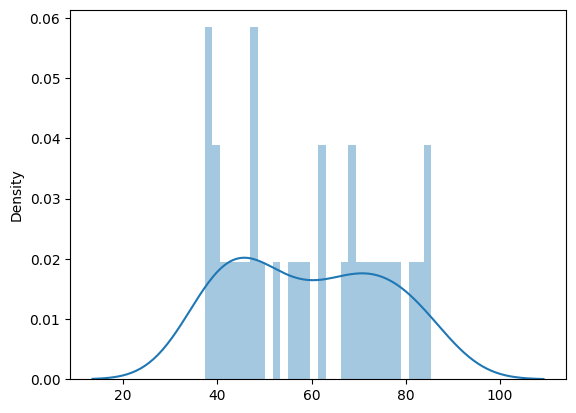

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

_ = sns.distplot(raw_outputs['plddt'].mean(dim=-1).mean(dim=-1).cpu().numpy(), bins=30)

In [23]:
import py3Dmol

# for i in range(len(pdb_strs)):
# for i in range(10,20): 
# for i in range(0, 10): 
for i in range(20,30): 
    view = py3Dmol.view(width=600, height=600)
    view.addModelsAsFrames(pdb_strs[i])
    
    # Apply the plDDT color scheme
    # view.setStyle({'cartoon': {'color': {'prop': 'b', 'gradient': 'roygb', 'min': 0, 'max': 100}}})
    view.setStyle({'cartoon': {'color': {'prop': 'b', 'gradient': 'roygb', 'min': 50, 'max': 90}}})
    
    # # Add surface representation with plDDT-based color
    view.addSurface(py3Dmol.VDW, {'opacity': 0.7, 'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 50, 'max': 90}})
    # view.addSurface(py3Dmol.VDW, {'opacity': 0.7, 'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 0, 'max': 100}})

    view.zoomTo()
    view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [24]:
from plaid.evaluation import RITAPerplexity

perplexity_calc = RITAPerplexity(device=device)
perplexities = perplexity_calc.batch_eval(sequences)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [25]:
perplexities = [perplexity_calc.calc_perplexity(s) for s in sequences]

/tmp/ipykernel_1246130/1157264804.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  _ = sns.distplot(perplexities, bins=30)


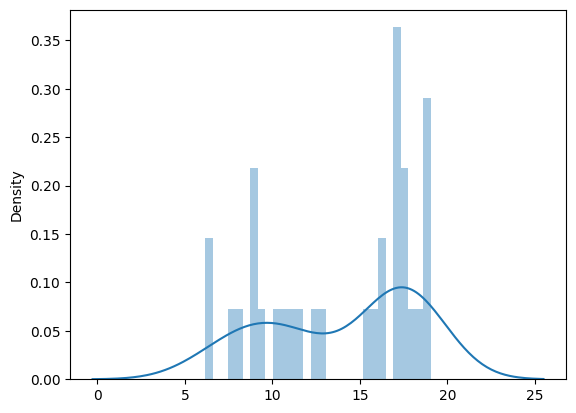

In [26]:
import seaborn as sns
_ = sns.distplot(perplexities, bins=30)

In [27]:
import numpy as np

np.mean(perplexities)

13.990363166080785